# Cuadernillo: Desbalanceo de clase
**Autor:** Gaddiel Esteban Nieto Rojas • **Fecha:** 2025-11-20

El cuadernillo presenta un proceso completo de análisis de morosidad crediticia basado en datos históricos, aplicando técnicas de preprocesamiento, balanceo y modelamiento supervisado. A través del uso de Python, Power BI y modelos predictivos, se busca identificar los factores más influyentes en la probabilidad de incumplimiento de pago.

> **Objetivos**
1. **Limpieza y preparación de datos:**  
   Se estandarizó la base de morosidad, corrigiendo valores faltantes y errores de formato.

2. **Análisis exploratorio:**  
   Se estudió la distribución de las variables financieras y sociodemográficas, detectando patrones relevantes.

3. **Análisis bivariado:**  
   Se evaluó la relación entre la variable objetivo (*morosidad*) y las variables explicativas.

4. **Balanceo de clases:**  
   Se aplicó la técnica **SMOTE** para equilibrar las proporciones entre clientes morosos y no morosos.

5. **Modelamiento predictivo:**  
   Se entrenaron y compararon modelos de **regresión logística**, **árbol de decisión** y **bosque aleatorio**.

6. **Evaluación del desempeño:**  
   Se seleccionó el modelo con mejor rendimiento según métricas como **F1-Score** y **AUC-ROC**.

7. **Visualización y presentación:**  
   Se exportaron los resultados a **Power BI** y se generó un resumen automático mediante la **API de Groq**, permitiendo interpretar los hallazgos de forma visual y ejecutiva.

In [1]:
from Funciones import build_sqlite_from_excels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
from pathlib import Path 
warnings.filterwarnings('ignore')
import os
import sys
import sqlite3
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)
import random

In [ ]:
SEED = 42
os.environ.setdefault("PYTHONHASHSEED", str(SEED))
random.seed(SEED)
np.random.seed(SEED)

DB_PATH = "data.sqlite"
os.makedirs("PowerBI", exist_ok=True)
os.makedirs("models", exist_ok=True)

if not os.path.exists(DB_PATH):
    build_sqlite_from_excels(resources_dir="Resources", db_path=DB_PATH)

conn = sqlite3.connect(DB_PATH)
try:
    cur = conn.cursor()
    cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
    existing = {r[0].lower() for r in cur.fetchall()}
    required_tables = {"train", "test", "sample"}
    missing = required_tables - existing
    if missing:
        build_sqlite_from_excels(resources_dir="Resources", db_path=DB_PATH)
        cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
        existing = {r[0].lower() for r in cur.fetchall()}
        missing = required_tables - existing
        if missing:
            raise RuntimeError(f"Faltan tablas en {DB_PATH}: {sorted(missing)}. Revisa Resources/ o build_sqlite_from_excels.")

    train = pd.read_sql_query("SELECT * FROM train", conn)
    test = pd.read_sql_query("SELECT * FROM test", conn)
    sample = pd.read_sql_query("SELECT * FROM sample", conn)


    if "id_cliente" in train.columns and train["id_cliente"].dtype != int:
        train["id_cliente"] = train["id_cliente"].astype(int)
    if "morosidad_en_2_años" in train.columns:
        train["morosidad_en_2_años"] = train["morosidad_en_2_años"].astype(int)

    print(f"DB cargada: {DB_PATH}")
    print(f"train: {train.shape}, test: {test.shape}, sample: {sample.shape}")
except Exception:
    conn.close()
    raise
finally:
    conn.close()

DB cargada: data.sqlite
train: (150000, 13), test: (16383, 12), sample: (16383, 3)


Guardado: PowerBI\distribucion_objetivo.png


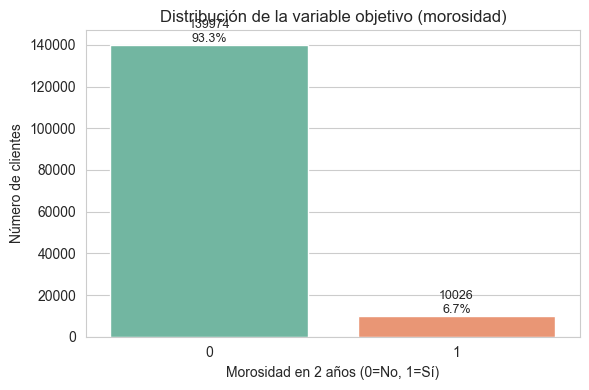

Guardado: PowerBI\distribuciones_numericas.png


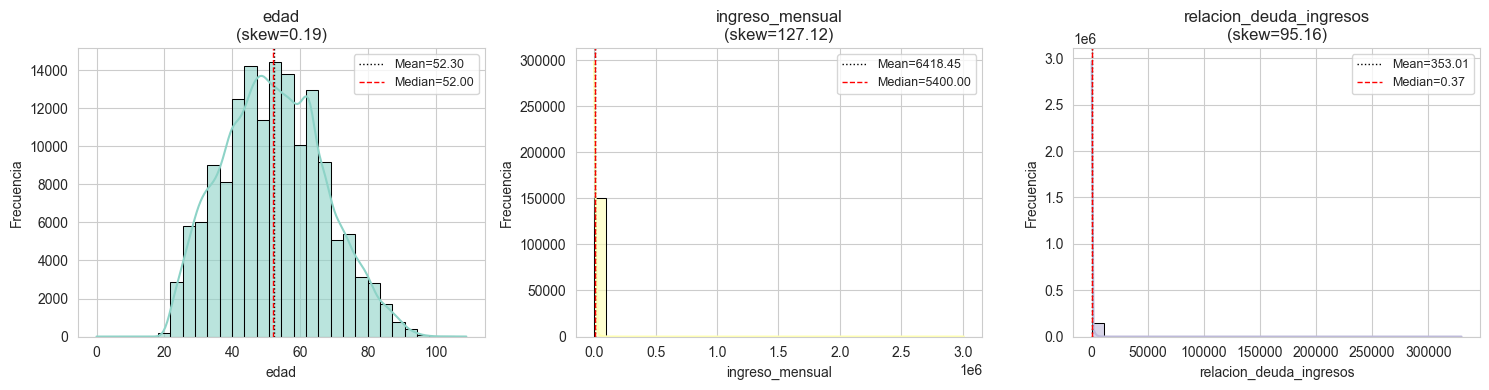

In [ ]:
sns.set_style("whitegrid")
cols = ["edad", "ingreso_mensual", "relacion_deuda_ingresos"]

os.makedirs("PowerBI", exist_ok=True)

plt.figure(figsize=(6,4))
order = sorted(train["morosidad_en_2_años"].unique())
ax = sns.countplot(data=train, x="morosidad_en_2_años", palette="Set2", order=order)
total = len(train)
for p in ax.patches:
    count = int(p.get_height())
    pct = 100 * count / total
    ax.annotate(f"{count}\n{pct:.1f}%", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center", va="bottom", fontsize=9)
ax.set_title("Distribución de la variable objetivo (morosidad)")
ax.set_xlabel("Morosidad en 2 años (0=No, 1=Sí)")
ax.set_ylabel("Número de clientes")
plt.tight_layout()

fig_obj = plt.gcf()
path_obj = Path("PowerBI") / "distribucion_objetivo.png"
fig_obj.savefig(path_obj, dpi=150)
print(f"Guardado: {path_obj}")

plt.show()

n = len(cols)
fig, axes = plt.subplots(1, n, figsize=(5*n, 4))
colors = sns.color_palette("Set3", n)

for i, col in enumerate(cols):
    ax = axes[i] if n > 1 else axes
    data = train[col].dropna()
    sns.histplot(data, bins=30, kde=True, ax=ax, color=colors[i], edgecolor='k', alpha=0.6)
    mean = data.mean()
    med = data.median()
    skew = data.skew()
    ax.axvline(mean, color='black', linestyle=':', linewidth=1, label=f"Mean={mean:.2f}")
    ax.axvline(med, color='red', linestyle='--', linewidth=1, label=f"Median={med:.2f}")
    ax.set_title(f"{col}\n(skew={skew:.2f})")
    ax.set_xlabel(col)
    ax.set_ylabel("Frecuencia")
    ax.legend(loc="upper right", fontsize=9)

    if col == "ingreso_mensual" and (data > 0).all() and abs(skew) > 1.0:
        ax.set_xscale("log")
        ax.set_xlabel(f"{col} (escala log)")
        try:
            ticks = ax.get_xticks()
            ax.set_xticklabels([f"{int(t):,}" if t >= 1 else f"{t:.2f}" for t in ticks])
        except Exception:
            pass

plt.tight_layout()

path_nums = Path("PowerBI") / "distribuciones_numericas.png"
fig.savefig(path_nums, dpi=150)
print(f"Guardado: {path_nums}")

plt.show()

Guardado: PowerBI\violin_box_edad.png


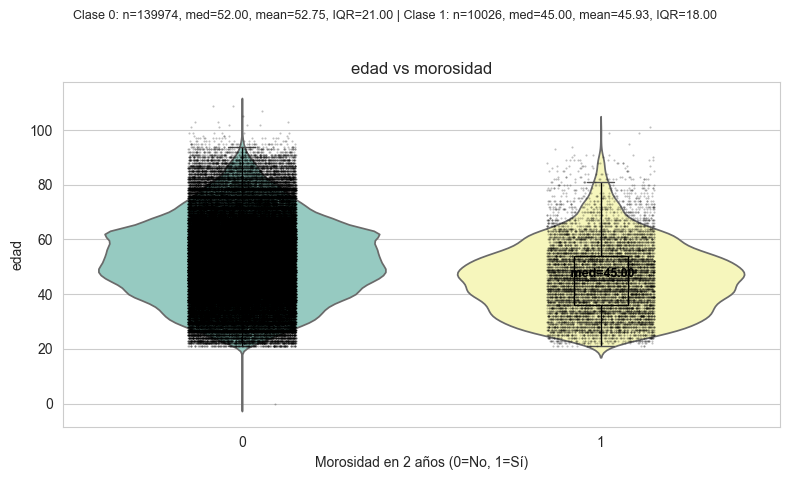

Guardado: PowerBI\violin_box_ingreso_mensual.png


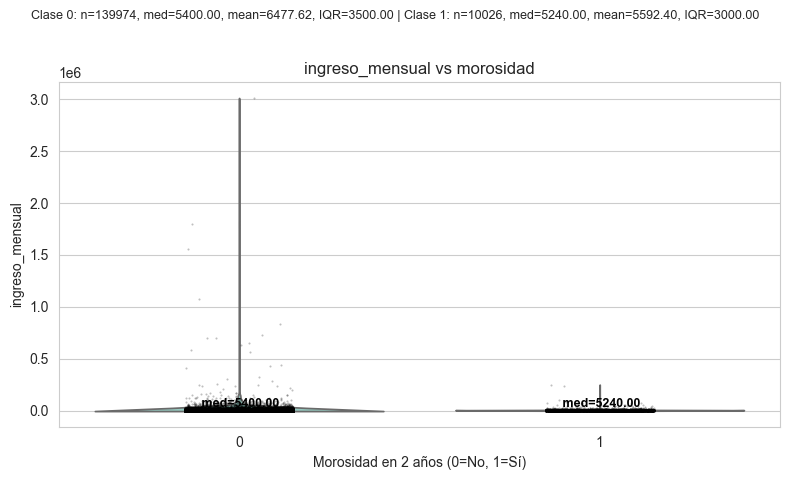

Guardado: PowerBI\violin_box_relacion_deuda_ingresos.png


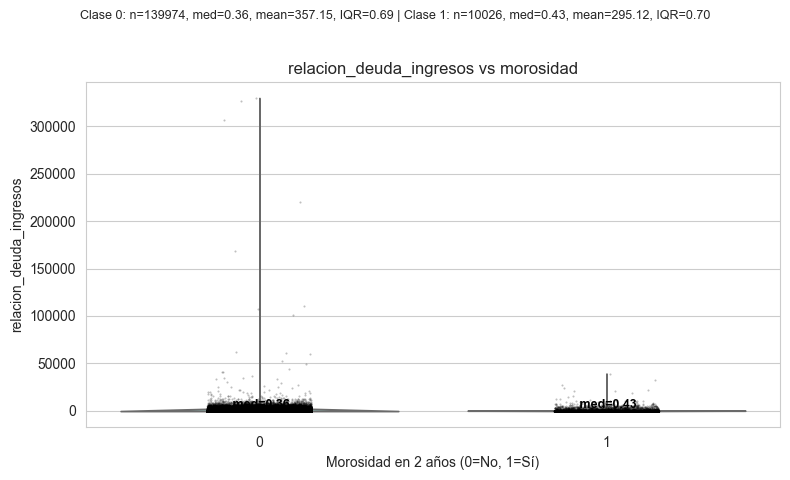

Guardado: PowerBI\matriz_correlacion_triangular.png


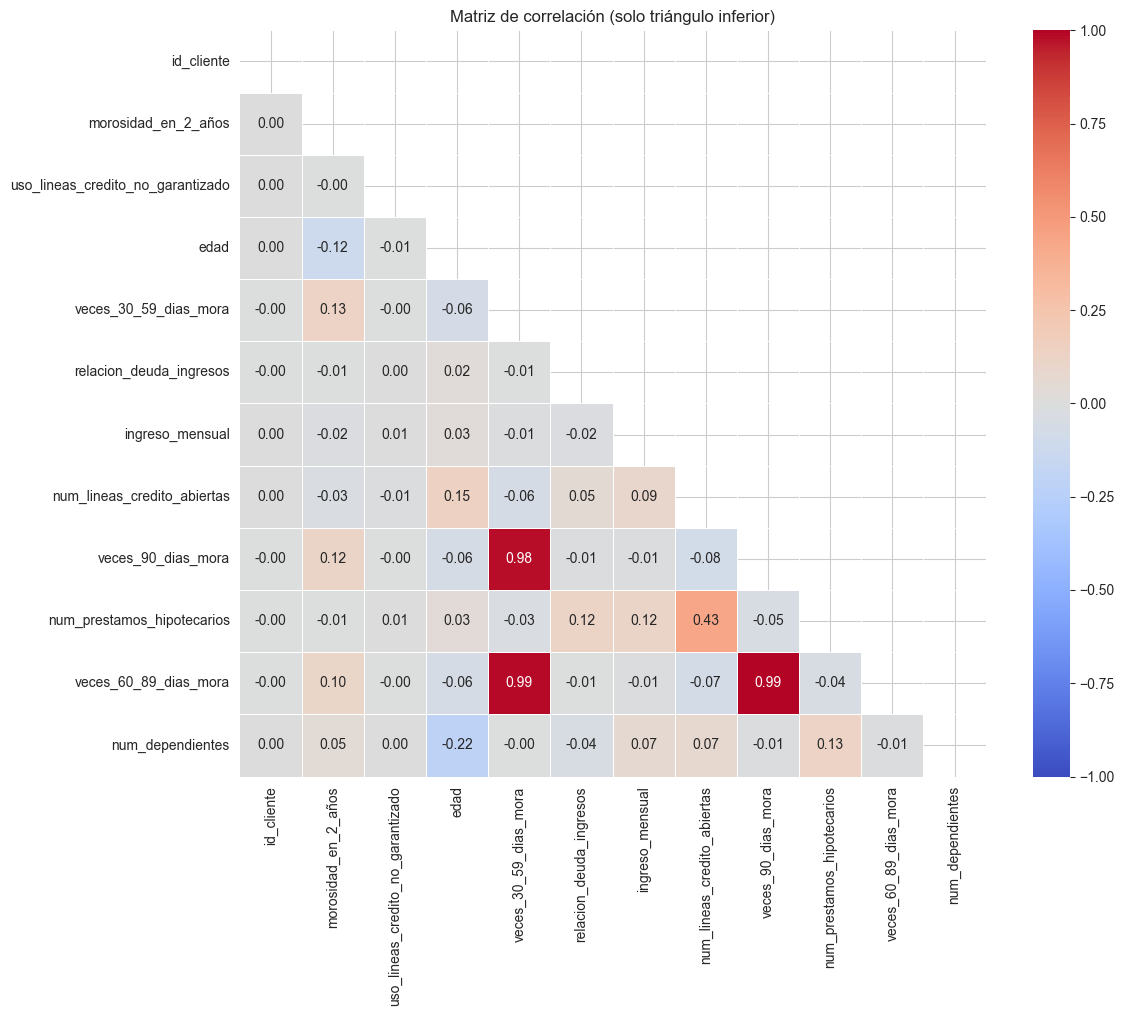

Guardado: PowerBI\top_correlacion_morosidad.png


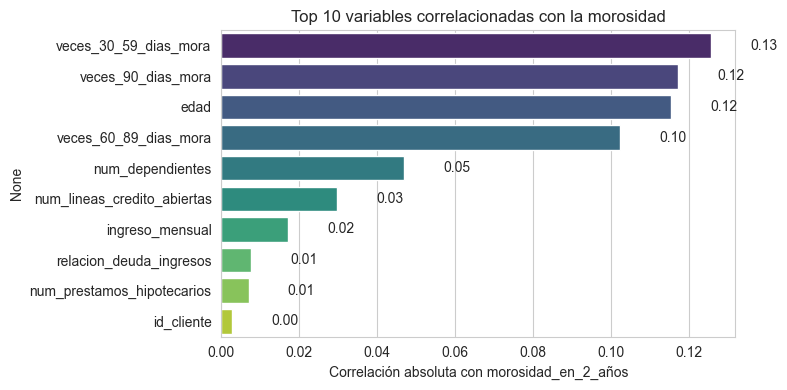

In [ ]:

os.makedirs("PowerBI", exist_ok=True)
for col in cols:
    s = train[col]
    use_log = False
    if col == "ingreso_mensual":
        if (s.dropna() > 0).all() and abs(s.dropna().skew()) > 1.0:
            use_log = True

    plot_series = np.log1p(s) if use_log else s
    ylabel = f"{col} (log1p)" if use_log else col

    plt.figure(figsize=(8,5))
    sns.violinplot(x="morosidad_en_2_años", y=plot_series, data=train, palette="Set3", inner=None)
    sns.boxplot(x="morosidad_en_2_años", y=plot_series, data=train,
                width=0.15, showcaps=True, boxprops={'facecolor':'none', 'edgecolor':'k'},
                showfliers=False, whiskerprops={'color':'k'})
    sns.stripplot(x="morosidad_en_2_años", y=plot_series, data=train, color='k', size=1.5, jitter=0.15, alpha=0.25)
    plt.title(f"{col} vs morosidad")
    plt.ylabel(ylabel)
    plt.xlabel("Morosidad en 2 años (0=No, 1=Sí)")

    stats_text = []
    for g in sorted(train["morosidad_en_2_años"].unique()):
        grp = plot_series[train["morosidad_en_2_años"] == g].dropna()
        n = len(grp)
        med = grp.median() if n>0 else np.nan
        mean = grp.mean() if n>0 else np.nan
        q1, q3 = (grp.quantile(0.25), grp.quantile(0.75)) if n>0 else (np.nan, np.nan)
        iqr = q3 - q1 if n>0 else np.nan
        stats_text.append(f"Clase {g}: n={n}, med={med:.2f}, mean={mean:.2f}, IQR={iqr:.2f}")
        x_pos = g
        y_pos = med
        plt.text(x_pos, y_pos, f" med={med:.2f}", va='bottom', ha='center', fontsize=9, color='black', weight='semibold')

    plt.suptitle(" | ".join(stats_text), fontsize=9, y=0.95)
    plt.tight_layout(rect=[0,0,1,0.93])

    try:
        fig = plt.gcf()
        fname = Path("PowerBI") / f"violin_box_{col}.png"
        fig.savefig(fname, dpi=150)
        print(f"Guardado: {fname}")
    except Exception as e:
        print(f"⚠️ No se pudo guardar figura {col}: {e}")

    plt.show()

numeric = train.select_dtypes(include=[np.number])
corr = numeric.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12,10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=.5, square=True)
plt.title("Matriz de correlación (solo triángulo inferior)")
plt.tight_layout()

try:
    fig = plt.gcf()
    fname = Path("PowerBI") / "matriz_correlacion_triangular.png"
    fig.savefig(fname, dpi=150)
    print(f"Guardado: {fname}")
except Exception as e:
    print(f"⚠️ No se pudo guardar matriz de correlación: {e}")

plt.show()

if "morosidad_en_2_años" in corr.columns:
    target_corr = corr["morosidad_en_2_años"].drop("morosidad_en_2_años").abs().sort_values(ascending=False)
    top_n = min(10, len(target_corr))
    plt.figure(figsize=(8,4))
    sns.barplot(x=target_corr.values[:top_n], y=target_corr.index[:top_n], palette="viridis")
    plt.xlabel("Correlación absoluta con morosidad_en_2_años")
    plt.title(f"Top {top_n} variables correlacionadas con la morosidad")
    for i, v in enumerate(target_corr.values[:top_n]):
        plt.text(v + 0.01, i, f"{v:.2f}", va='center')
    plt.tight_layout()

    try:
        fig = plt.gcf()
        fname = Path("PowerBI") / "top_correlacion_morosidad.png"
        fig.savefig(fname, dpi=150)
        print(f"Guardado: {fname}")
    except Exception as e:
        print(f"⚠️ No se pudo guardar gráfico de correlaciones: {e}")

    plt.show()

In [ ]:
X = train.drop(columns=[c for c in ["morosidad_en_2_años", "id_cliente"] if c in train.columns])
y = train["morosidad_en_2_años"]

X = X.select_dtypes(include=[np.number]).copy()

imputer = SimpleImputer(strategy="median")
X_imp = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

skews = X_imp.skew()
to_log = [c for c in skews.index if (abs(skews[c]) > 1.0) and (X_imp[c] > 0).all()]
if to_log:
    X_imp[to_log] = np.log1p(X_imp[to_log])

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    X_imp, y, test_size=0.3, random_state=SEED, stratify=y
)

smote = SMOTE(random_state=SEED)
X_entrenamiento_bal_np, y_entrenamiento_bal = smote.fit_resample(X_entrenamiento, y_entrenamiento)

X_entrenamiento_bal = pd.DataFrame(X_entrenamiento_bal_np, columns=X_imp.columns)

zero_var_cols = X_entrenamiento_bal.columns[X_entrenamiento_bal.var(axis=0) == 0].tolist()
if zero_var_cols:
    X_entrenamiento_bal = X_entrenamiento_bal.drop(columns=zero_var_cols)
    X_prueba = X_prueba.drop(columns=[c for c in zero_var_cols if c in X_prueba.columns])

scaler = StandardScaler()
X_entrenamiento_bal = pd.DataFrame(scaler.fit_transform(X_entrenamiento_bal),
                                   columns=X_entrenamiento_bal.columns)
X_prueba = X_prueba.reindex(columns=X_entrenamiento_bal.columns, fill_value=0)
X_prueba = pd.DataFrame(scaler.transform(X_prueba), columns=X_prueba.columns, index=X_prueba.index)

feat_cols = X_entrenamiento_bal.columns

print(f"Preprocesado completado: X_entrenamiento_bal={X_entrenamiento_bal.shape}, X_prueba={X_prueba.shape}, y_entrenamiento_bal={y_entrenamiento_bal.shape}")
if to_log:
    print(f"Se aplicó log1p a: {to_log}")
if zero_var_cols:
    print(f"Columnas con varianza cero eliminadas: {zero_var_cols}")

Preprocesado completado: X_entrenamiento_bal=(195964, 10), X_prueba=(45000, 10), y_entrenamiento_bal=(195964,)


In [6]:
resultados = []
roc_curves = {} 
conf_matrices = {}

In [ ]:
required = ["X_entrenamiento_bal", "y_entrenamiento_bal", "X_prueba", "y_prueba"]
missing = [v for v in required if v not in globals()]
if missing:
    raise NameError(f"Faltan variables: {missing}. Ejecuta la celda de preprocesado antes de entrenar.")

for var in ["X_entrenamiento_bal", "X_prueba"]:
    df = globals()[var]
    if not isinstance(df, pd.DataFrame) or df.shape[1] == 0:
        raise ValueError(f"{var} no tiene columnas válidas.")

modelos = {
    "Regresion_Logistica": LogisticRegression(max_iter=500, random_state=SEED),
    "Arbol_Decision": DecisionTreeClassifier(max_depth=6, random_state=SEED),
    "Bosque_Aleatorio": RandomForestClassifier(n_estimators=100, random_state=SEED)
}
print("Modelos inicializados correctamente y listos para entrenamiento.")

Modelos inicializados correctamente y listos para entrenamiento.


In [ ]:
for nombre, modelo in modelos.items():
    modelo.fit(X_entrenamiento_bal, y_entrenamiento_bal)

prob_logreg = modelos["Regresion_Logistica"].predict_proba(X_prueba)[:, 1]
prob_arbol = modelos["Arbol_Decision"].predict_proba(X_prueba)[:, 1]
prob_bosque = modelos["Bosque_Aleatorio"].predict_proba(X_prueba)[:, 1]

pred_logreg = modelos["Regresion_Logistica"].predict(X_prueba)
pred_arbol = modelos["Arbol_Decision"].predict(X_prueba)
pred_bosque = modelos["Bosque_Aleatorio"].predict(X_prueba)

df_out = X_prueba.copy()
df_out["id_cliente"] = train.loc[X_prueba.index, "id_cliente"].values
df_out["morosidad_en_2_años"] = y_prueba.values

df_out["Probabilidad_LogReg"] = prob_logreg
df_out["Probabilidad_Arbol"] = prob_arbol
df_out["Probabilidad_Bosque"] = prob_bosque

df_out["Pred_LogReg"] = pred_logreg
df_out["Pred_Arbol"] = pred_arbol
df_out["Pred_Bosque"] = pred_bosque

p_pct = (df_out["Probabilidad_Bosque"].fillna(0) * 100).round(2)
df_out["Score_Riesgo"] = p_pct
df_out["Riesgo_Calificado"] = pd.cut(
    p_pct,
    bins=[-1, 33, 66, 100],
    labels=["Bajo", "Medio", "Alto"]
).astype(str)

edad_vals = df_out["edad"].copy()
if edad_vals.isnull().any():
    edad_vals = edad_vals.fillna(edad_vals.median())
df_out["Categoria_Edad"] = pd.cut(
    edad_vals,
    bins=[0, 25, 40, 60, 120],
    labels=["Joven", "Adulto", "Maduro", "Mayor"]
).astype(str)

ingreso_vals = df_out["ingreso_mensual"].copy()
if ingreso_vals.isnull().any():
    ingreso_vals = ingreso_vals.fillna(ingreso_vals.median())
df_out["Categoria_Ingreso"] = pd.cut(
    ingreso_vals,
    bins=[-1, 2000, 5000, 10000, 1e12],
    labels=["Bajo", "Medio", "Medio-Alto", "Alto"]
).astype(str)

print("Datos modelados y enriquecidos listos para exportar")

Datos modelados y enriquecidos listos para exportar


In [ ]:
conn = sqlite3.connect(DB_PATH)
df_out.to_sql("test_modelado", conn, if_exists="replace", index=False)
df_out.to_sql("powerbi_features", conn, if_exists="replace", index=False)
conn.close()

csv_path = Path("PowerBI") / "test_modelado_export.csv"
df_out.to_csv(csv_path, index=False)

rf = modelos["Bosque_Aleatorio"]
importancias = rf.feature_importances_
imp_df = pd.DataFrame({
    "feature": feat_cols,
    "importance": importancias
})
imp_df = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)
imp_df["importance_pct"] = (imp_df["importance"] * 100).round(3)
imp_df["cumulative_pct"] = imp_df["importance_pct"].cumsum().round(3)

imp_df.to_excel("PowerBI/importancia_variables.xlsx", index=False)
imp_df.to_csv("PowerBI/importancia_variables.csv", index=False)

try:
    conn = sqlite3.connect(DB_PATH)
    imp_df.to_sql("importancia_variables", conn, if_exists="replace", index=False)
    conn.close()
except Exception:
    pass

print("✔ Tablas test_modelado y powerbi_features creadas en SQLite")
print(f"✔ CSV exportado a {csv_path}")
print("✔ Importancia de variables exportada a PowerBI/importancia_variables.xlsx y .csv")

✔ Tablas test_modelado y powerbi_features creadas en SQLite
✔ CSV exportado a PowerBI\test_modelado_export.csv
✔ Importancia de variables exportada a PowerBI/importancia_variables.xlsx y .csv


In [ ]:
os.makedirs("models", exist_ok=True)
saved_models = []
for nombre, modelo in modelos.items():
    try:
        joblib.dump(modelo, f"models/{nombre}.joblib")
        saved_models.append(nombre)
    except Exception as e:
        print(f"⚠️ Error guardando {nombre}: {e}")

dax_texto = """
-- Medidas resumen para Power BI
Total_Clientes = COUNTROWS(powerbi_features)

Clientes_Morosos = CALCULATE(COUNTROWS(powerbi_features), FILTER(powerbi_features, powerbi_features[morosidad_en_2_años] = 1))
Clientes_No_Morosos = CALCULATE(COUNTROWS(powerbi_features), FILTER(powerbi_features, powerbi_features[morosidad_en_2_años] = 0))

Tasa_Morosidad = DIVIDE([Clientes_Morosos], [Total_Clientes], 0)

-- Exactitud global por modelo (conteo de coincidencias / total)
Accuracy_LogReg = DIVIDE( COUNTROWS( FILTER(powerbi_features, powerbi_features[Pred_LogReg] = powerbi_features[morosidad_en_2_años]) ), [Total_Clientes], 0)
Accuracy_Arbol = DIVIDE( COUNTROWS( FILTER(powerbi_features, powerbi_features[Pred_Arbol] = powerbi_features[morosidad_en_2_años]) ), [Total_Clientes], 0)
Accuracy_Bosque = DIVIDE( COUNTROWS( FILTER(powerbi_features, powerbi_features[Pred_Bosque] = powerbi_features[morosidad_en_2_años]) ), [Total_Clientes], 0)

-- Promedios de probabilidad / score
Prob_Prom_LogReg = AVERAGE(powerbi_features[Probabilidad_LogReg])
Prob_Prom_Arbol = AVERAGE(powerbi_features[Probabilidad_Arbol])
Prob_Prom_Bosque = AVERAGE(powerbi_features[Probabilidad_Bosque])
Promedio_Score_Riesgo = AVERAGE(powerbi_features[Score_Riesgo])

-- Conteos por nivel de riesgo
Clientes_Alto_Riesgo = CALCULATE(COUNTROWS(powerbi_features), FILTER(powerbi_features, powerbi_features[Riesgo_Calificado] = \"Alto\"))
Clientes_Medio_Riesgo = CALCULATE(COUNTROWS(powerbi_features), FILTER(powerbi_features, powerbi_features[Riesgo_Calificado] = \"Medio\"))
Clientes_Bajo_Riesgo = CALCULATE(COUNTROWS(powerbi_features), FILTER(powerbi_features, powerbi_features[Riesgo_Calificado] = \"Bajo\"))
"""

os.makedirs("PowerBI", exist_ok=True)
with open("PowerBI/powerbi_medidas_dax.txt", "w", encoding="utf-8") as f:
    f.write(dax_texto)

print(f"✔ Medidas DAX generadas en PowerBI/powerbi_medidas_dax.txt")
print(f"✔ Modelos guardados: {saved_models}")

✔ Medidas DAX generadas en PowerBI/powerbi_medidas_dax.txt
✔ Modelos guardados: ['Regresion_Logistica', 'Arbol_Decision', 'Bosque_Aleatorio']


In [ ]:
for nombre, modelo in modelos.items():
    resultados[:] = [r for r in resultados if r.get("modelo") != nombre]
    roc_curves.pop(nombre, None)
    conf_matrices.pop(nombre, None)

    y_pred = modelo.predict(X_prueba)

    y_prob = None
    if hasattr(modelo, "predict_proba"):
        try:
            probs = modelo.predict_proba(X_prueba)
            if probs.ndim == 2 and probs.shape[1] >= 2:
                try:
                    pos_idx = list(modelo.classes_).index(1)
                except Exception:
                    pos_idx = 1
                y_prob = probs[:, pos_idx]
            else:
                y_prob = probs.ravel()
        except Exception:
            y_prob = None

    if y_prob is None and hasattr(modelo, "decision_function"):
        try:
            scores = modelo.decision_function(X_prueba)
            scores = np.asarray(scores, dtype=float)
            smin, smax = scores.min(), scores.max()
            if smax == smin:
                y_prob = np.full(scores.shape, 0.5, dtype=float)
            else:
                y_prob = (scores - smin) / (smax - smin)
        except Exception:
            y_prob = None

    if y_prob is None:
        y_prob = np.full_like(y_pred, fill_value=float(np.mean(y_pred)), dtype=float)

    if len(y_prob) != len(y_prueba) or len(y_pred) != len(y_prueba):
        print(f"⚠️ Longitud de predicciones/probabilidades no coincide para {nombre}. Se omite registro.")
        continue

    acc = accuracy_score(y_prueba, y_pred)
    prec = precision_score(y_prueba, y_pred, zero_division=0)
    rec = recall_score(y_prueba, y_pred, zero_division=0)
    f1 = f1_score(y_prueba, y_pred, zero_division=0)

    try:
        if len(np.unique(y_prueba)) > 1 and np.nanstd(y_prob) > 0:
            auc = roc_auc_score(y_prueba, y_prob)
        else:
            auc = np.nan
    except Exception:
        auc = np.nan

    cm = confusion_matrix(y_prueba, y_pred)
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
    else:
        full = np.zeros((2,2), dtype=int)
        unique_preds = np.unique(np.concatenate([y_prueba.values if hasattr(y_prueba, "values") else y_prueba, y_pred]))
        for i, true_val in enumerate([0,1]):
            for j, pred_val in enumerate([0,1]):
                full[i,j] = int(((y_prueba == true_val) & (y_pred == pred_val)).sum())
        tn, fp, fn, tp = full.ravel()
        cm = full

    resultados.append({
        "modelo": nombre,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "auc_roc": auc,
        "tn": int(tn),
        "fp": int(fp),
        "fn": int(fn),
        "tp": int(tp),
        "support_positivos": int((y_prueba == 1).sum()),
        "support_negativos": int((y_prueba == 0).sum())
    })

    try:
        if len(np.unique(y_prueba)) > 1 and np.nanstd(y_prob) > 0:
            fpr, tpr, _ = roc_curve(y_prueba, y_prob)
            roc_curves[nombre] = (fpr, tpr, auc)
    except Exception:
        pass

    cm_df = pd.DataFrame(cm,
                         index=["Verdadero_NoMoroso (0)", "Verdadero_Moroso (1)"],
                         columns=["Predicho_NoMoroso (0)", "Predicho_Moroso (1)"]).astype(int)
    with np.errstate(divide='ignore', invalid='ignore'):
        cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cm_norm_df = pd.DataFrame(cm_norm,
                                  index=cm_df.index,
                                  columns=cm_df.columns).fillna(0).round(3)
    conf_matrices[nombre] = {"absolute": cm_df, "normalized": cm_norm_df}
    print(conf_matrices[nombre]["absolute"])

                        Predicho_NoMoroso (0)  Predicho_Moroso (1)
Verdadero_NoMoroso (0)                  34296                 7696
Verdadero_Moroso (1)                     1089                 1919
                        Predicho_NoMoroso (0)  Predicho_Moroso (1)
Verdadero_NoMoroso (0)                  40833                 1159
Verdadero_Moroso (1)                     2065                  943
                        Predicho_NoMoroso (0)  Predicho_Moroso (1)
Verdadero_NoMoroso (0)                  41291                  701
Verdadero_Moroso (1)                     2273                  735


In [ ]:
with pd.ExcelWriter("PowerBI/matrices_confusion.xlsx", engine="openpyxl") as writer:
        for nombre, cm_obj in conf_matrices.items():
            base = nombre.replace(" ", "_")[:25]  
            if isinstance(cm_obj, dict):
                abs_df = cm_obj.get("absolute")
                norm_df = cm_obj.get("normalized")
                if isinstance(abs_df, pd.DataFrame):
                    abs_df.to_excel(writer, sheet_name=f"{base}_abs")
                if isinstance(norm_df, pd.DataFrame):
                    norm_df.to_excel(writer, sheet_name=f"{base}_norm")
            elif isinstance(cm_obj, pd.DataFrame):
                cm_obj.to_excel(writer, sheet_name=base)
print("✔ Evaluación de modelos completada y resultados guardados en PowerBI/matrices_confusion.xlsx")
resultados_df = pd.DataFrame(resultados)
resultados_df.to_excel("PowerBI/resumen_resultados_modelos.xlsx", index=False)
print("✔ Resumen de resultados guardado en PowerBI/resumen_resultados_modelos.xlsx")

✔ Evaluación de modelos completada y resultados guardados en PowerBI/matrices_confusion.xlsx
✔ Resumen de resultados guardado en PowerBI/resumen_resultados_modelos.xlsx



Tabla resumen de métricas por modelo:


,Modelo,Exactitud,Precisión,Sensibilidad (Recall),F1-Score,AUC-ROC,TN,FP,FN,TP,Soporte_Pos (1),Soporte_Neg (0),Mejor_Modelo
0,Arbol_Decision,0.9284,0.4486,0.3135,0.3691,0.8380,40833,1159,2065,943,3008,41992,True
1,Bosque_Aleatorio,0.9339,0.5118,0.2443,0.3308,0.8361,41291,701,2273,735,3008,41992,False
2,Regresion_Logistica,0.8048,0.1996,0.6380,0.3040,0.8010,34296,7696,1089,1919,3008,41992,False


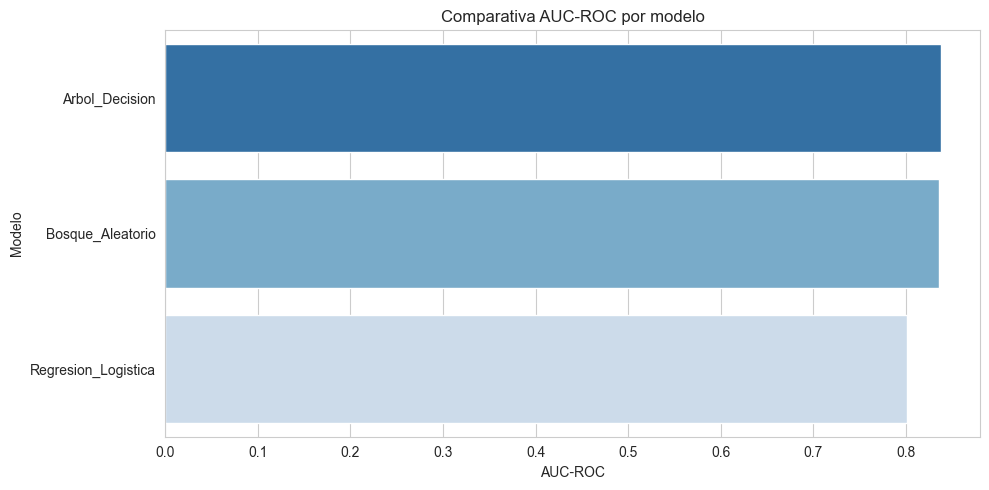

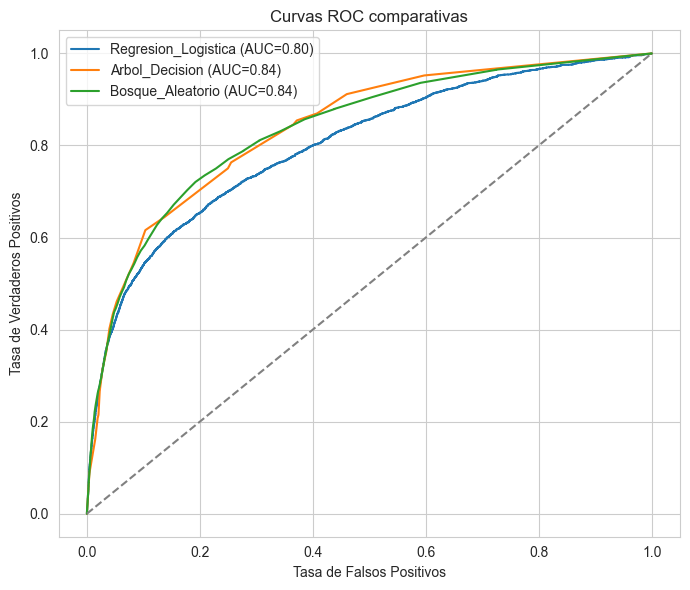

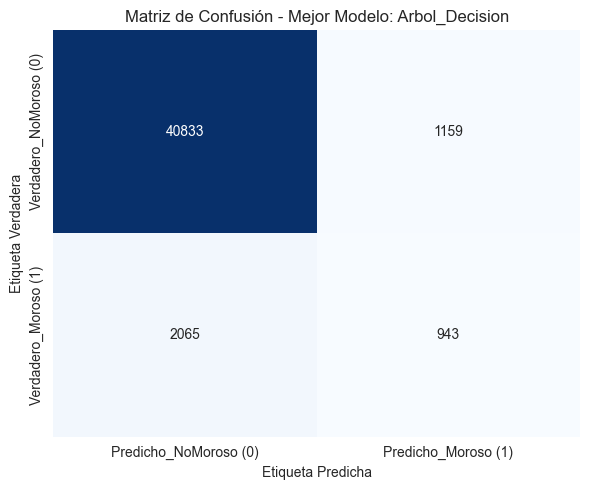


Archivos generados en carpeta PowerBI/:
- resultados_modelos.xlsx / .csv
- matrices_confusion.xlsx
- plot_auc_comparativa.png
- roc_comparativa.png
- matriz_confusion_mejor_modelo.png (si existe)

Modelos guardados en carpeta models/ (incluye mejor_modelo.joblib si se determinó).


In [ ]:
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by="auc_roc", ascending=False).reset_index(drop=True)

mejor_idx = df_resultados["auc_roc"].idxmax() if df_resultados["auc_roc"].notna().any() else 0
df_resultados["mejor_modelo"] = False
if not df_resultados.empty:
    df_resultados.loc[mejor_idx, "mejor_modelo"] = True

df_resultados = df_resultados.rename(columns={
    "modelo": "Modelo",
    "accuracy": "Exactitud",
    "precision": "Precisión",
    "recall": "Sensibilidad (Recall)",
    "f1_score": "F1-Score",
    "auc_roc": "AUC-ROC",
    "tn": "TN",
    "fp": "FP",
    "fn": "FN",
    "tp": "TP",
    "support_positivos": "Soporte_Pos (1)",
    "support_negativos": "Soporte_Neg (0)",
    "mejor_modelo": "Mejor_Modelo"
})

for col in ["Exactitud", "Precisión", "Sensibilidad (Recall)", "F1-Score", "AUC-ROC"]:
    if col in df_resultados.columns:
        df_resultados[col] = df_resultados[col].round(4)

from IPython.display import display
print("\nTabla resumen de métricas por modelo:")
display(df_resultados)

df_resultados.to_excel("PowerBI/resultados_modelos.xlsx", index=False)
df_resultados.to_csv("PowerBI/resultados_modelos.csv", index=False)

conn = sqlite3.connect("data.sqlite")
df_resultados.to_sql("resultados_modelos", conn, if_exists="replace", index=False)

plt.figure(figsize=(10,5))
sns.barplot(data=df_resultados.sort_values("AUC-ROC", ascending=False),
            x="AUC-ROC", y="Modelo", palette="Blues_r")
plt.title("Comparativa AUC-ROC por modelo")
plt.xlabel("AUC-ROC")
plt.tight_layout()
plt.savefig("PowerBI/plot_auc_comparativa.png")
plt.show()
saved = []

plt.figure(figsize=(7,6))
for nombre, (fpr, tpr, auc_val) in roc_curves.items():
    label = f"{nombre} (AUC={auc_val:.2f})" if auc_val == auc_val else nombre
    plt.plot(fpr, tpr, label=label)
plt.plot([0,1],[0,1],'--', color='gray')
plt.title("Curvas ROC comparativas")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.legend()
plt.tight_layout()
plt.savefig("PowerBI/roc_comparativa.png")
plt.show()

best_model_name = df_resultados.loc[df_resultados["Mejor_Modelo"], "Modelo"].values
if len(best_model_name) > 0:
    best_model_name = best_model_name[0]
    if best_model_name in conf_matrices:
        cm_best = conf_matrices[best_model_name]["absolute"]
        plt.figure(figsize=(6,5))
        sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Matriz de Confusión - Mejor Modelo: {best_model_name}")
        plt.ylabel("Etiqueta Verdadera")
        plt.xlabel("Etiqueta Predicha")
        plt.tight_layout()
        plt.savefig("PowerBI/matriz_confusion_mejor_modelo.png")
        plt.show()

print("\nArchivos generados en carpeta PowerBI/:")
print("- resultados_modelos.xlsx / .csv")
print("- matrices_confusion.xlsx")
print("- plot_auc_comparativa.png")
print("- roc_comparativa.png")
print("- matriz_confusion_mejor_modelo.png (si existe)")
print("\nModelos guardados en carpeta models/ (incluye mejor_modelo.joblib si se determinó).")


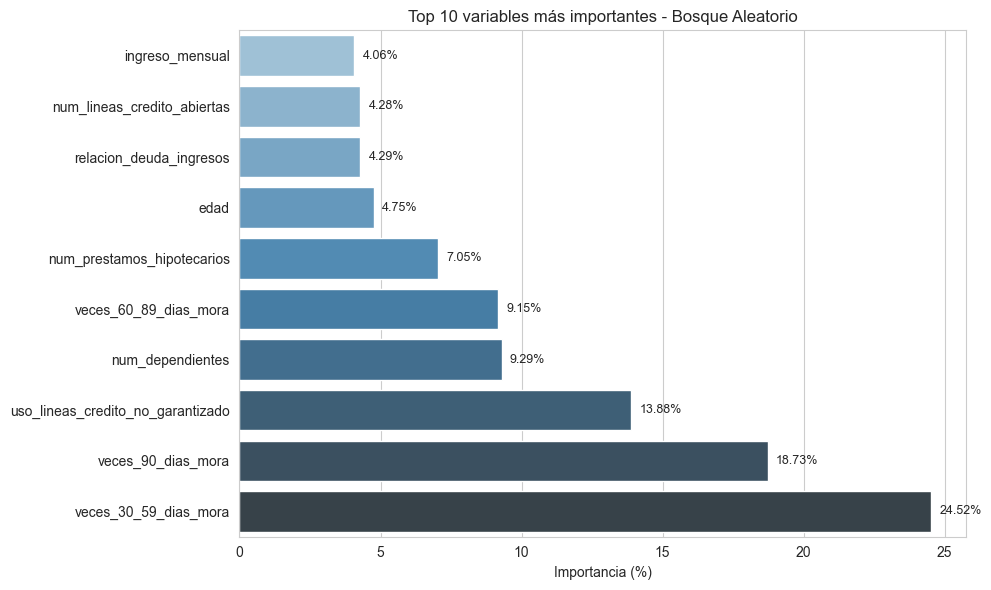

Exportación completada: PowerBI/importancia_variables_completa.{xlsx,csv}, PowerBI/importancia_variables_top10.xlsx, PowerBI/importancia_variables_top10.png


In [ ]:
if "Bosque_Aleatorio" not in modelos or not hasattr(modelos["Bosque_Aleatorio"], "feature_importances_"):
    raise RuntimeError("El modelo 'Bosque_Aleatorio' no existe o no tiene 'feature_importances_'.")

features = feat_cols if "feat_cols" in globals() else (X.columns if "X" in globals() else None)
if features is None:
    raise RuntimeError("No se encontraron nombres de características (feat_cols o X).")

importancias = modelos["Bosque_Aleatorio"].feature_importances_
imp_df = pd.DataFrame({"feature": list(features), "importance": importancias})
imp_df = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)
imp_df["importance_pct"] = (imp_df["importance"] * 100).round(3)
imp_df["cumulative_pct"] = imp_df["importance_pct"].cumsum().round(3)

os.makedirs("PowerBI", exist_ok=True)

top_n = 10
top = imp_df.head(top_n).iloc[::-1]  

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x="importance_pct", y="feature", data=top, palette="Blues_d")
ax.set_xlabel("Importancia (%)")
ax.set_ylabel("")
ax.set_title(f"Top {top_n} variables más importantes - Bosque Aleatorio")

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.3, p.get_y() + p.get_height() / 2,
            f"{width:.2f}%", va="center", fontsize=9)

plt.tight_layout()
plt.savefig("PowerBI/importancia_variables_top10.png", dpi=150)
plt.show()

imp_df.to_excel("PowerBI/importancia_variables_completa.xlsx", index=False)
imp_df.to_csv("PowerBI/importancia_variables_completa.csv", index=False)
top.iloc[::-1].to_excel("PowerBI/importancia_variables_top10.xlsx", index=False)  

try:
    conn = sqlite3.connect(DB_PATH)
    imp_df.to_sql("importancia_variables", conn, if_exists="replace", index=False)
    conn.close()
except Exception:
    pass

print("Exportación completada: PowerBI/importancia_variables_completa.{xlsx,csv}, PowerBI/importancia_variables_top10.xlsx, PowerBI/importancia_variables_top10.png")